In [5]:
import numpy as np
import torch
from torch.nn import BatchNorm2d, Conv1d, Conv2d, ModuleList, Parameter
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from captum.attr import IntegratedGradients

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [77]:
river_dl = np.load("../../river-dl/results/baseline/RGCN/prepped.npz")

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

ajd_matrix = river_dl['dist_matrix']
batch_size = ajd_matrix.shape[0]

x.shape, y.shape, ajd_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [78]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out

def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss



In [124]:
model = RGCN_v1(7, 20, ajd_matrix)
model.load_state_dict(torch.load('../../river-dl/results/baseline/RGCN/rep_5/finetuned_weights.pth', map_location='cpu'))
# Apply XAI and visualize

<All keys matched successfully>

In [125]:
ig = IntegratedGradients(model)

In [126]:
n_series = river_dl['x_trn'].shape[0]
baseline = river_dl['x_trn'].reshape(n_series//455,455,180,7)

In [127]:
baseline=torch.from_numpy(baseline)
baseline=torch.mean(baseline[:,0,...],dim=0).reshape(1,180,7).float()
model.eval()
model(x)
x[0:1].shape, baseline.shape

ValueError: too many values to unpack (expected 3)

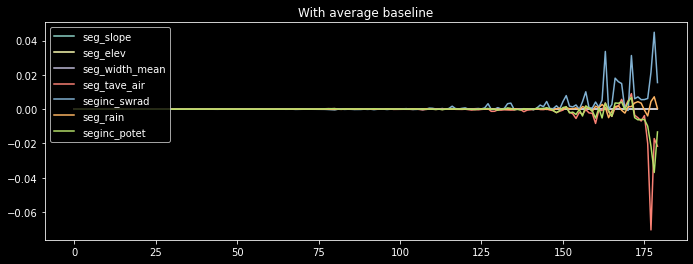

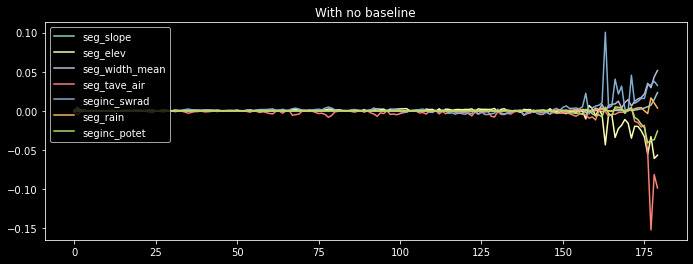

In [83]:
attributions = ig.attribute(x[0:1],baseline, n_steps = batch_size, target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.title('With average baseline')
plt.pause(0.001)



attributions = ig.attribute(x[0:1], n_steps = batch_size, target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.title('With no baseline')
plt.pause(0.001)



# sort the top vars by IGs (absolute value sum along time series)
#biggest_ig = torch.argsort(torch.sum(torch.abs(attributions), dim = 1), descending = True)
#biggest_ig = biggest_ig.squeeze()[:5]

#plt.figure(figsize = (11.5, 4))
#for i in biggest_ig:
#    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
#plt.legend();

In [48]:
ig.attribute?


In [128]:
x = torch.from_numpy(river_dl['x_trn']).float().reshape(n_series//455,455,180,7) # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]
baseline = torch.mean(x,dim=0)#.reshape(1,180,7).float()
model.eval()
preds = model(x[0])
x.shape, x[0].shape, baseline.shape, preds.shape

(torch.Size([107, 455, 180, 7]),
 torch.Size([455, 180, 7]),
 torch.Size([455, 180, 7]),
 torch.Size([455, 180, 1]))

In [138]:
attributions = ig.attribute(x[0],baseline, internal_batch_size=455, target = (-1,0)) # attributions for last day in the sequence

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

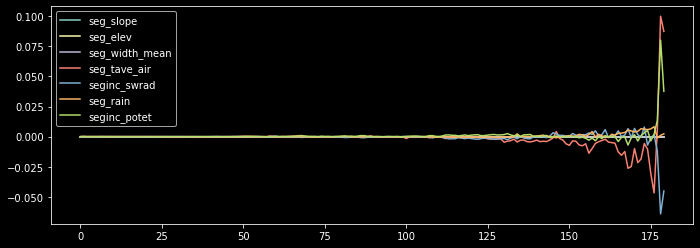

In [139]:
plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0,:, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

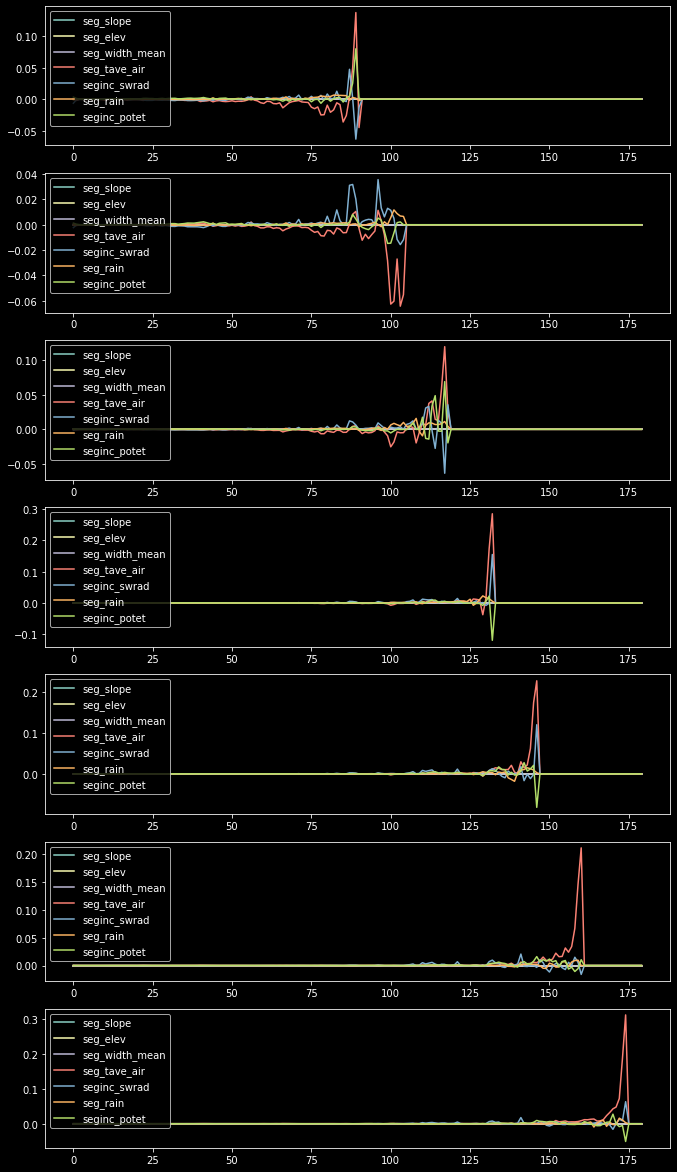

In [86]:
plt.style.use('dark_background')
obs = range(90,180,14)
num_plots = len(obs)
fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,21))

for (ob,ax) in zip(obs,axes):
    attributions = ig.attribute(x[1],baseline, internal_batch_size=455, target = ob) # attributions for last day in the sequence
    for i in range(7):
        ax.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
    ax.legend(loc = 'upper left')
plt.tight_layout

## Define GWN

In [118]:
def nconv(x, A):
    """Multiply x by adjacency matrix along source node axis"""
    return torch.einsum('ncvl,vw->ncwl', (x, A)).contiguous()

class GraphConvNet(nn.Module):
    def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
        super().__init__()
        c_in = (order * support_len + 1) * c_in
        self.final_conv = Conv2d(c_in, c_out, (1, 1), padding=(0, 0), stride=(1, 1), bias=True)
        self.dropout = dropout
        self.order = order

    def forward(self, x, support: list):
        out = [x]
        for a in support:
            x1 = nconv(x, a)
            out.append(x1)
            for k in range(2, self.order + 1):
                x2 = nconv(x1, a)
                out.append(x2)
                x1 = x2

        h = torch.cat(out, dim=1)
        h = self.final_conv(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h
class gwnet(nn.Module):
    def __init__(self, device, num_nodes, dropout=0.3, supports=None, gcn_bool=True,
                 addaptadj=True, aptinit=None, in_dim=2, out_dim=12,
                 residual_channels=32, dilation_channels=32,
                 skip_channels=256, end_channels=512, kernel_size=2, blocks=4, layers=2,
                 apt_size=10, cat_feat_gc=False):
        super().__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.cat_feat_gc = cat_feat_gc
        self.addaptadj = addaptadj


        if self.cat_feat_gc:
            self.start_conv = nn.Conv2d(in_channels=1,  # hard code to avoid errors
                                        out_channels=residual_channels,
                                        kernel_size=(1, 1))
            self.cat_feature_conv = nn.Conv2d(in_channels=in_dim - 1,
                                              out_channels=residual_channels,
                                              kernel_size=(1, 1))
        else:
            self.start_conv = nn.Conv2d(in_channels=in_dim,
                                        out_channels=residual_channels,
                                        kernel_size=(1, 1))

        self.fixed_supports = supports or []
        receptive_field = 1

        self.supports_len = len(self.fixed_supports)
        if gcn_bool and addaptadj:
            if aptinit is None:
                nodevecs = torch.randn(num_nodes, apt_size), torch.randn(apt_size, num_nodes)
            else:
                nodevecs = self.svd_init(apt_size, aptinit)
            self.supports_len += 1
            self.nodevec1, self.nodevec2 = [Parameter(n.to(device), requires_grad=True) for n in nodevecs]

        depth = list(range(blocks * layers))

        # 1x1 convolution for residual and skip connections (slightly different see docstring)
        self.residual_convs = ModuleList([Conv1d(dilation_channels, residual_channels, (1, 1)) for _ in depth])
        self.skip_convs = ModuleList([Conv1d(dilation_channels, skip_channels, (1, 1)) for _ in depth])
        self.bn = ModuleList([BatchNorm2d(residual_channels) for _ in depth])
        self.graph_convs = ModuleList([GraphConvNet(dilation_channels, residual_channels, dropout, support_len=self.supports_len)
                                              for _ in depth])

        self.filter_convs = ModuleList()
        self.gate_convs = ModuleList()
        for b in range(blocks):
            additional_scope = kernel_size - 1
            D = 1 # dilation
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(Conv2d(residual_channels, dilation_channels, (1, kernel_size), dilation=D))
                self.gate_convs.append(Conv1d(residual_channels, dilation_channels, (1, kernel_size), dilation=D))
                D *= 2
                receptive_field += additional_scope
                additional_scope *= 2
        self.receptive_field = receptive_field

        self.end_conv_1 = Conv2d(skip_channels, end_channels, (1, 1), bias=True)
        self.end_conv_2 = Conv2d(end_channels, out_dim, (1, 1), bias=True)

    @staticmethod
    def svd_init(apt_size, aptinit):
        m, p, n = torch.svd(aptinit)
        nodevec1 = torch.mm(m[:, :apt_size], torch.diag(p[:apt_size] ** 0.5))
        nodevec2 = torch.mm(torch.diag(p[:apt_size] ** 0.5), n[:, :apt_size].t())
        return nodevec1, nodevec2

    @classmethod
    def from_args(cls, args, device, supports, aptinit, **kwargs):
        defaults = dict(dropout=args.dropout, supports=supports,
                        do_graph_conv=args.gcn_bool, addaptadj=args.addaptadj, aptinit=aptinit,
                        in_dim=args.in_dim, apt_size=args.apt_size, out_dim=args.seq_length,
                        residual_channels=args.nhid, dilation_channels=args.nhid,
                        skip_channels=args.nhid * 8, end_channels=args.nhid * 16,
                        cat_feat_gc=args.cat_feat_gc)
        defaults.update(**kwargs)
        model = cls(device, args.num_nodes, **defaults)
        return model

    def load_checkpoint(self, state_dict):
        """It is assumed that ckpt was trained to predict a subset of timesteps."""
        bk, wk = ['end_conv_2.bias', 'end_conv_2.weight']  # only weights that depend on seq_length
        b, w = state_dict.pop(bk), state_dict.pop(wk)
        self.load_state_dict(state_dict, strict=False)
        cur_state_dict = self.state_dict()
        cur_state_dict[bk][:b.shape[0]] = b
        cur_state_dict[wk][:w.shape[0]] = w
        self.load_state_dict(cur_state_dict)

    def forward(self, x):
        # Input shape is (bs, features, n_nodes, n_timesteps)
        in_len = x.size(3)
        if in_len < self.receptive_field:
            x = nn.functional.pad(x, (self.receptive_field - in_len, 0, 0, 0))
        if self.cat_feat_gc:
            f1, f2 = x[:, [0]], x[:, 1:]
            x1 = self.start_conv(f1)
            x2 = F.leaky_relu(self.cat_feature_conv(f2))
            x = x1 + x2
        else:
            x = self.start_conv(x)
        skip = 0
        adjacency_matrices = self.fixed_supports
        # calculate the current adaptive adj matrix once per iteration
        if self.addaptadj:
            adp = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)
            adjacency_matrices = self.fixed_supports + [adp]

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # EACH BLOCK

            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |   |-dil_conv -- tanh --|                |
            #         ---|                  * ----|-- 1x1 -- + -->	*x_in*
            #                |-dil_conv -- sigm --|    |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + ------------->	*skip*
            residual = x
            # dilated convolution
            filter = torch.tanh(self.filter_convs[i](residual))
            gate = torch.sigmoid(self.gate_convs[i](residual))
            x = filter * gate
            # parametrized skip connection
            s = self.skip_convs[i](x)  # what are we skipping??
            try:  # if i > 0 this works
                skip = skip[:, :, :,  -s.size(3):]  # TODO(SS): Mean/Max Pool?
            except:
                skip = 0
            skip = s + skip
            if i == (self.blocks * self.layers - 1):  # last X getting ignored anyway
                break

            if self.gcn_bool:
                graph_out = self.graph_convs[i](x, adjacency_matrices)
                x = x + graph_out if self.cat_feat_gc else graph_out
            else:
                x = self.residual_convs[i](x)
            x = x + residual[:, :, :, -x.size(3):]  # TODO(SS): Mean/Max Pool?
            x = self.bn[i](x)

        x = F.relu(skip)  # ignore last X?
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)  # downsample to (bs, seq_length, 207, nfeatures)
        return x.transpose(1,3)



def reshape_for_gwn(cat_data, keep_portion=None):
    """
    Helper function to reshape input data for GraphWaveNet Model
    @param cat_data: dictionary or path to .npz file
    @param keep_portion: [float]  If < 1, fraction of prediction sequence to keep, if >1, absolute length to keep
    @return: [dict] reformatted data
    """
    if isinstance(cat_data, str):
        cat_data = np.load(cat_data)
    n_segs = len(np.unique(cat_data['ids_trn']))

    files = ['x_pre_full',
             'x_trn',
             'x_val',
             'x_tst',
             'ids_trn',
             'times_trn',
             'ids_val',
             'times_val',
             'ids_tst',
             'times_tst',
             'y_obs_trn',
             'y_obs_wgts',
             'y_obs_val',
             'y_obs_tst',
             'y_pre_full',
             'y_pre_trn']

    cat_reshaped = {}
    for i in files:
        shapes_rdl = cat_data[i].shape
        reshaped = cat_data[i].reshape(int(shapes_rdl[0] / n_segs), n_segs, shapes_rdl[1], shapes_rdl[2])
        reshaped = np.moveaxis(reshaped,3,1)
        #reshaped = np.transpose(reshaped,(0,3,2,1))
        cat_reshaped[i] = reshaped
        ## shape in n_batch*nseg,seq_len,n_var
        ## shape out batches, n_var, n_seg, n_seq_len

    for file in set(cat_data.files) - set(files):
        cat_reshaped[file] = cat_data[file]

    files_y = list(filter(lambda x: 'y_' in x, files))
    if keep_portion is not None:
        if keep_portion > 1:
            period = int(keep_portion)
        else:
            seq_len = cat_reshaped['y_obs_trn'].shape[3]
            period = int(keep_portion * seq_len)
        for i in files_y:
            cat_reshaped[i] = cat_reshaped[i][:,:,:,-period:]
    return cat_reshaped

In [61]:
data = np.load("../../river-dl/results/baseline/GWN/prepped.npz")
data = reshape_for_gwn(data,keep_portion= 15)
adj_mx = data['dist_matrix']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
supports = [torch.tensor(adj_mx).to(device).float()]
in_dim = len(data['x_vars'])
out_dim = data['y_obs_trn'].shape[3]
num_nodes = adj_mx.shape[0]

In [140]:
model = gwnet(device,num_nodes,supports=supports,aptinit=supports[0],
    in_dim=in_dim,out_dim=out_dim,layers=3, kernel_size=5,blocks=3)
model.load_state_dict(torch.load('../../river-dl/results/baseline/GWN/rep_5/finetuned_weights.pth', map_location='cpu'))
ig = IntegratedGradients(model)

In [141]:
x = torch.from_numpy(data['x_trn']).float() # use the last year of data for all 455 segments
baseline = torch.mean(x,dim=0).unsqueeze(dim=0)
x[0:1].shape, baseline.shape

(torch.Size([1, 7, 455, 60]), torch.Size([1, 7, 455, 60]))

In [142]:
model.eval()
preds = model(x[0:1])
preds.shape

torch.Size([1, 1, 455, 15])

In [146]:
attributions = ig.attribute(x[0:1], baseline, n_steps=20, target=(0,0,-1)) # attributions for last day in the sequence

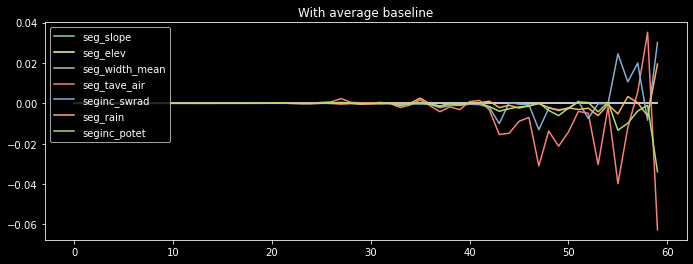

In [147]:
plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0,i,0,:], label = data['x_vars'][i])
plt.legend(loc = 'upper left')
plt.title('With average baseline')
plt.pause(0.001)

In [ ]:
attributions = ig.attribute(x[0:1], target = -1) # attributions for last day in the sequence

plt.figure(figsize = (11.5, 4))
for i in range(7):
    plt.plot(attributions[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.title('With no baseline')
plt.pause(0.001)